<a href="https://colab.research.google.com/github/amber3536/Drug-evaluation/blob/main/Drug_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import seaborn as sns

# Drug evalution project

This project aims to determine the sets of proteins whose abundances are significantly perturbed by treatment with a drug with at least a given concentration. This is important because detecting which proteins become over- or under-expressed in response to a drug treatment indicates that the drug could be useful to treat conditions where protein expression changes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Using data from UCSD's Center for Computational Mass Spectrometry of kinase inhibitors currently in clinical trials.

https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=35824d83f2b44a7fa677608a4fa8ed3c

In [ ]:
df = pd.read_csv("drive/MyDrive/MERGE_MAESTRO-a19fe3be-mq_variants_intensity-main.tsv", sep='\t', low_memory=False, thousands=',')

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,rowid,ccms_row_id,Variant,Variant ID,Unmod variant,Total,Total- Unmodified sequence,Variants- Unmodified sequence,Proteins,Mass,Charge,Num Mods,All Mods,Is Decoy,Lorikeet input,Orig cluster FDR,Pep Prefix,Variant FDR,Peptidoform,Canonical proteins,Top protein,Top canonical protein,Top protein FDR,Top canonical protein FDR,Rep cluster task,Rep cluster user,Rep cluster index,Num tasks,Outlier groups,Outlier group ratio,Outlier groups- unmod,Outlier group ratio- unmod,Unmod_Variant,_dyn_#AEE-788_inBT474 1000nM.Tech replicate 1 of 1,_dyn_#AEE-788_inBT474 1000nM.Tech replicate 1 of 1_unmod,_dyn_#AEE-788_inBT474 100nM.Tech replicate 1 of 1,_dyn_#AEE-788_inBT474 100nM.Tech replicate 1 of 1_unmod,_dyn_#AEE-788_inBT474 10nM.Tech replicate 1 of 1,_dyn_#AEE-788_inBT474 10nM.Tech replicate 1 of 1_unmod,_dyn_#AEE-788_inBT474 30000nM.Tech replicate 1 of 1,_dyn_#AEE-788_inBT474 30000nM.Tech replicate 1 of 1_unmod,_dyn_#AEE-788_inBT474 3000nM.Tech replicate 1 of 1,_dyn_#AEE-788_inBT474 3000nM.Tech replicate 1 of 1_unmod,_dyn_#AEE-788_inBT474 300nM.Tech replicate 1 of 1,_dyn_#AEE-788_inBT474 300nM.Tech replicate 1 of 1_unmod,_dyn_#AEE-788_inBT474 30nM.Tech replicate 1 of 1,_dyn_#AEE-788_inBT474 30nM.Tech replicate 1 of 1_unmod,_dyn_#AEE-788_inBT474 3nM.Tech replicate 1 of 1,_dyn_#AEE-788_inBT474 3nM.Tech replicate 1 of 1_unmod,_dyn_#AEE-788_inBT474 DMSO.Tech replicate 1 of 1,_dyn_#AEE-788_inBT474 DMSO.Tech replicate 1 of 1_unmod,_dyn_#AEE-788_inBT474 PDPD.Tech replicate 1 of 1,_dyn_#AEE-788_inBT474 PDPD.Tech replicate 1 of 1_unmod,_dyn_#AEW-541 1000nM.Tech replicate 1 of 1,_dyn_#AEW-541 1000nM.Tech replicate 1 of 1_unmod,_dyn_#AEW-541 100nM.Tech replicate 1 of 1,_dyn_#AEW-541 100nM.Tech replicate 1 of 1_unmod,_dyn_#AEW-541 10nM.Tech replicate 1 of 1,_dyn_#AEW-541 10nM.Tech replicate 1 of 1_unmod,_dyn_#AEW-541 30000nM.Tech replicate 1 of 1,_dyn_#AEW-541 30000nM.Tech replicate 1 of 1_unmod,_dyn_#AEW-541 3000nM.Tech replicate 1 of 1,_dyn_#AEW-541 3000nM.Tech replicate 1 of 1_unmod,_dyn_#AEW-541 300nM.Tech replicate 1 of 1,_dyn_#AEW-541 300nM.Tech replicate 1 of 1_unmod,_dyn_#AEW-541 30nM.Tech replicate 1 of 1,_dyn_#AEW-541 30nM.Tech replicate 1 of 1_unmod,_dyn_#AEW-541 3nM.Tech replicate 1 of 1,_dyn_#AEW-541 3nM.Tech replicate 1 of 1_unmod,_dyn_#AEW-541 DMSO.Tech replicate 1 of 1,_dyn_#AEW-541 DMSO.Tech replicate 1 of 1_unmod,_dyn_#AEW-541 PDPD.Tech replicate 1 of 1,_dyn_#AEW-541 PDPD.Tech replicate 1 of 1_unmod,_dyn_#AMG-208 1000nM.Tech replicate 1 of 1,_dyn_#AMG-208 1000nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208 100nM.Tech replicate 1 of 1,_dyn_#AMG-208 100nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208 10nM.Tech replicate 1 of 1,_dyn_#AMG-208 10nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208 30000nM.Tech replicate 1 of 1,_dyn_#AMG-208 30000nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208 3000nM.Tech replicate 1 of 1,_dyn_#AMG-208 3000nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208 300nM.Tech replicate 1 of 1,_dyn_#AMG-208 300nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208 30nM.Tech replicate 1 of 1,_dyn_#AMG-208 30nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208 3nM.Tech replicate 1 of 1,_dyn_#AMG-208 3nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208 DMSO.Tech replicate 1 of 1,_dyn_#AMG-208 DMSO.Tech replicate 1 of 1_unmod,_dyn_#AMG-208 PDPD.Tech replicate 1 of 1,_dyn_#AMG-208 PDPD.Tech replicate 1 of 1_unmod,_dyn_#AMG-208_withCAKI 1000nM.Tech replicate 1 of 1,_dyn_#AMG-208_withCAKI 1000nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208_withCAKI 100nM.Tech replicate 1 of 1,_dyn_#AMG-208_withCAKI 100nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208_withCAKI 10nM.Tech replicate 1 of 1,_dyn_#AMG-208_withCAKI 10nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208_withCAKI 30000nM.Tech replicate 1 of 1,_dyn_#AMG-208_withCAKI 30000nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208_withCAKI 3000nM.Tech replicate 1 of 1,_dyn_#AMG-208_withCAKI 3000nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208_withCAKI 300nM.Tech replicate 1 of 1,_dyn_#AMG-208_withCAKI 300nM.Tech replicate 1 of 1_unmod,_dyn_#AMG-208

In [ ]:
def getDMSOMean(df):
    f = [col for col in df if 'DMSO' in col]
    df5 = df[f]
    df5 = df5.assign(mean= df5.mean(axis=1))
    return df5['mean']

In [ ]:
def preprocess(df, protein, drug):
    df.drop(list(df.filter(regex = 'unmod')), axis = 1, inplace = True)
    df2 = df[df['Top canonical protein'] == protein]
    f = [col for col in df if drug in col]
    df2 = df2[f]
    o = [col for col in df2 if 'PDPD' not in col]
    df2 = df2[o]
    df2.columns = ['1000nM', '100nM', '10nM', '30000nM', '3000nM', '300nM', '30nM', '3nM', 'DMSO']
    df2 = df2[['3nM', '10nM', '30nM', '100nM', '300nM', '1000nM', '3000nM', '30000nM', 'DMSO']]
    df2 = df2.dropna(how='all')
    df2['Variant'] = df['Variant']
    df2['Unmod variant'] = df['Unmod variant']
    df2['Proteins'] = df['Proteins']
    return df2

In [ ]:
df2 = preprocess(df, 'sp|Q14204|DYHC1_HUMAN', 'AT-13148')
df2.head()

,3nM,10nM,30nM,100nM,300nM,1000nM,3000nM,30000nM,DMSO,Variant,Unmod variant,Proteins
1650,5704700.0,8022600.0,12816000.0,33707000.0,NaN,28472000.0,10203000.0,16023000.0,11530000.0,.VPQIEVETHK.,.VPQIEVETHK.,sp|Q14204|DYHC1_HUMAN;tr|A0A2R8YFZ7|A0A2R8YFZ7...
1722,4594000.0,5527200.0,NaN,14882000.0,30123000.0,30126000.0,10598000.0,NaN,25972000.0,.QYASYEFVQR.,.QYASYEFVQR.,sp|Q14204|DYHC1_HUMAN
2223,10528000.0,16860000.0,25383000.0,20931000.0,58774000.0,39876000.0,21392000.0,21165000.0,56302000.0,.VTDFGDKVEDPTFLNQLQSGVNR.,.VTDFGDKVEDPTFLNQLQSGVNR.,sp|Q14204|DYHC1_HUMAN
2364,5707000.0,8859600.0,NaN,23516000.0,31894000.0,NaN,12411000.0,16130000.0,15278000.0,.IQGLTVEQAEAVVR.,.IQGLTVEQAEAVVR.,sp|Q14204|DYHC1_HUMAN;tr|A0A2R8Y542|A0A2R8Y542...
2743,1519600.0,2229100.0,3785500.0,NaN,22176000.0,10618000.0,4534600.0,4444600.0,14779000.0,.AHQANQLYPFAISLIESVR.,.AHQANQLYPFAISLIESVR.,sp|Q14204|DYHC1_HUMAN


In [ ]:
df3 = preprocess(df, 'sp|P49327|FAS_HUMAN', 'AT-13148')
df3.head()

,3nM,10nM,30nM,100nM,300nM,1000nM,3000nM,30000nM,DMSO,Variant,Unmod variant,Proteins
1502,26429000.0,35196000.0,72552000.0,189320000.0,317240000.0,84233000.0,42236000.0,53592000.0,169230000.0,.RPTPQDSPIFLPVDDTSFR.,.RPTPQDSPIFLPVDDTSFR.,sp|P49327|FAS_HUMAN;tr|A0A0U1RQF0|A0A0U1RQF0_H...
1871,6716200.0,2633200.0,4664500.0,74793000.0,81125000.0,45851000.0,4980700.0,12711000.0,34019000.0,.FDASFFGVHPK.,.FDASFFGVHPK.,sp|P49327|FAS_HUMAN;tr|A0A0U1RQF0|A0A0U1RQF0_H...
2174,16181000.0,19751000.0,31927000.0,157490000.0,219710000.0,95460000.0,29811000.0,35640000.0,NaN,.IPGLLSPHPLLQLSYTATDR.,.IPGLLSPHPLLQLSYTATDR.,sp|P49327|FAS_HUMAN;tr|A0A0U1RQF0|A0A0U1RQF0_H...
2208,11789000.0,16247000.0,45241000.0,200660000.0,366490000.0,118950000.0,36734000.0,37226000.0,250340000.0,.LHLSGIDANPNALFPPVEFPAPR.,.LHLSGIDANPNALFPPVEFPAPR.,sp|P49327|FAS_HUMAN;tr|A0A0U1RQF0|A0A0U1RQF0_H...
2257,6927000.0,11110000.0,16311000.0,118150000.0,66215000.0,64131000.0,15861000.0,17014000.0,111970000.0,.LFDHPESPTPNPTEPLFLAQAEVYK.,.LFDHPESPTPNPTEPLFLAQAEVYK.,sp|P49327|FAS_HUMAN;tr|A0A0U1RQF0|A0A0U1RQF0_H...


In [ ]:
df4 = preprocess(df, 'sp|Q14204|DYHC1_HUMAN', 'Alectinib')
df4.head()

,3nM,10nM,30nM,100nM,300nM,1000nM,3000nM,30000nM,DMSO,Variant,Unmod variant,Proteins
1650,6321000.0,8023500.0,7347600.0,8296100.0,10273000.0,2796200.0,2178500.0,1992400.0,3623700.0,.VPQIEVETHK.,.VPQIEVETHK.,sp|Q14204|DYHC1_HUMAN;tr|A0A2R8YFZ7|A0A2R8YFZ7...
1722,NaN,8039500.0,7885300.0,NaN,NaN,1723700.0,2207200.0,2036800.0,4139900.0,.QYASYEFVQR.,.QYASYEFVQR.,sp|Q14204|DYHC1_HUMAN
2223,8648500.0,9202400.0,10866000.0,8722100.0,11886000.0,NaN,2984300.0,2196000.0,6242400.0,.VTDFGDKVEDPTFLNQLQSGVNR.,.VTDFGDKVEDPTFLNQLQSGVNR.,sp|Q14204|DYHC1_HUMAN
2364,7045600.0,8051200.0,8008600.0,7282500.0,10405000.0,1973800.0,2541400.0,1423400.0,3467600.0,.IQGLTVEQAEAVVR.,.IQGLTVEQAEAVVR.,sp|Q14204|DYHC1_HUMAN;tr|A0A2R8Y542|A0A2R8Y542...
2928,NaN,NaN,NaN,5744500.0,5588300.0,5283200.0,5704000.0,NaN,NaN,.VKDDIESLHDKFK.,.VKDDIESLHDKFK.,sp|Q14204|DYHC1_HUMAN


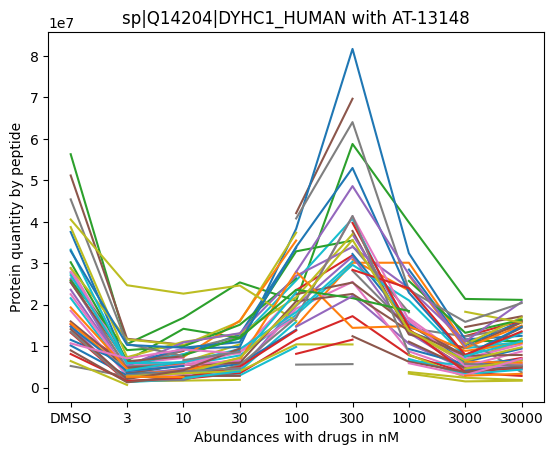

In [ ]:
for i in range(len(df2)):   # for each row:
    plt.plot([df2.iloc[i,8], df2.iloc[i,0], df2.iloc[i,1], df2.iloc[i,2], df2.iloc[i,3], df2.iloc[i,4], df2.iloc[i,5], df2.iloc[i,6], df2.iloc[i,7]])
plt.xlabel('Abundances with drugs in nM')
labels = ['DMSO','3', '10', '30', '100', '300', '1000', '3000', '30000']
plt.xticks([0,1,2,3,4,5,6,7,8], labels)
plt.title('sp|Q14204|DYHC1_HUMAN with AT-13148')
plt.ylabel('Protein quantity by peptide')
plt.show()

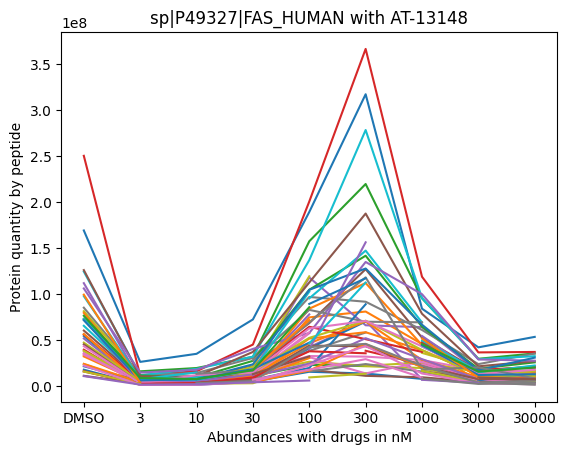

In [ ]:
for i in range(len(df3)):   # for each row:
    plt.plot([df3.iloc[i,8], df3.iloc[i,0], df3.iloc[i,1], df3.iloc[i,2], df3.iloc[i,3], df3.iloc[i,4], df3.iloc[i,5], df3.iloc[i,6], df3.iloc[i,7]])
plt.xlabel('Abundances with drugs in nM')
labels = ['DMSO','3', '10', '30', '100', '300', '1000', '3000', '30000']
plt.xticks([0,1,2,3,4,5,6,7,8], labels)
plt.title('sp|P49327|FAS_HUMAN with AT-13148')
plt.ylabel('Protein quantity by peptide')
plt.show()

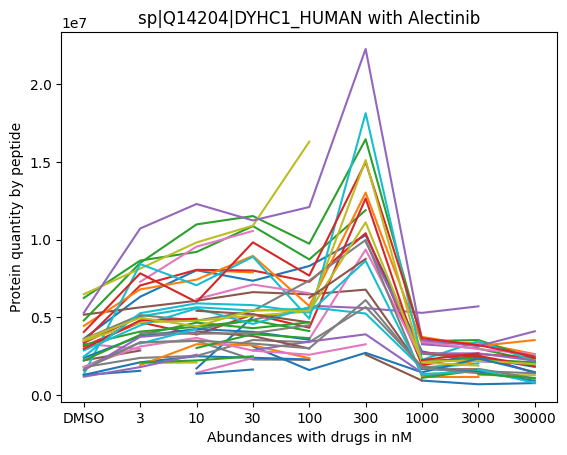

In [ ]:
for i in range(len(df4)):   # for each row:
    plt.plot([df4.iloc[i,8], df4.iloc[i,0], df4.iloc[i,1], df4.iloc[i,2], df4.iloc[i,3], df4.iloc[i,4], df4.iloc[i,5], df4.iloc[i,6], df4.iloc[i,7]])
plt.xlabel('Abundances with drugs in nM')
labels = ['DMSO','3', '10', '30', '100', '300', '1000', '3000', '30000']
plt.xticks([0,1,2,3,4,5,6,7,8], labels)
plt.title('sp|Q14204|DYHC1_HUMAN with Alectinib')
plt.ylabel('Protein quantity by peptide')
plt.show()

In [ ]:
def t_test(df, equal_var, direction):
    mean = np.log(df['DMSO'])
    d = df.iloc[:, 0:8]
    d = np.log(d)
    U = []
    for i in range(len(df)):
        y = stats.ttest_ind(mean, d.iloc[i], axis=0, nan_policy='omit', equal_var=equal_var, alternative=direction)
        U.append((y.pvalue, df.iloc[i, 10]))
    return U

In [ ]:
def getPercent(z):
    count = 0
    total = 0
    for i in range(len(z)):
        if z[i][0] < .05:
            count += 1
            total += 1
        elif not np.ma.is_masked(z[i][0]):
            #print(z[i][0])
            total += 1
    return (count/total)

## t-Test

In [ ]:
z = t_test(df2, False, 'greater')
z.sort()
getPercent(z)

0.6

In [ ]:
x = t_test(df3, False, 'two-sided')
x.sort()
getPercent(x)

0.43283582089552236

In [ ]:
y = t_test(df4, False, 'two-sided')
y.sort()
getPercent(y)

0.3064516129032258

## Heatmaps

In [ ]:
top_uniq = sorted(z)
#top_uniq = top_uniq[:10]
top_uniq

[(2.1240835117686663e-07, '.GWENHVEGQK.'),
 (0.00015140819663988215, '.FNYGFEYLGVQDK.'),
 (0.0003921472243747274, '.TPVSITEHPK.'),
 (0.0006655386339891325, '.VPVNLLR.'),
 (0.0017571268931421721, '.ESPEVLLTLDILK.'),
 (0.0023452189201843715, '.VQYPQSQACK.'),
 (0.00264723320239306, '.VDNEFDQR.'),
 (0.006325689457112773, '.AHQANQLYPFAISLIESVR.'),
 (0.007833170373759638, '.VNFLPEIITLSK.'),
 (0.009154012833813336, '.HVPVVYVDYPGPASLTQIYGTFNR.')]

In [ ]:
top_uniq = [lis[-1] for lis in top_uniq]
np.unique(top_uniq)

array(['.AHQANQLYPFAISLIESVR.', '.ESPEVLLTLDILK.', '.FNYGFEYLGVQDK.',
       '.GWENHVEGQK.', '.HVPVVYVDYPGPASLTQIYGTFNR.', '.TPVSITEHPK.',
       '.VDNEFDQR.', '.VNFLPEIITLSK.', '.VPVNLLR.', '.VQYPQSQACK.'],
      dtype='<U26')

In [ ]:
d_4 = df2.loc[df2['Unmod variant'].isin(top_uniq)]
d_4 = d_4.set_index('Unmod variant')
d_4 = d_4.drop(columns=['Variant', 'Proteins', 'DMSO'])
#d_4['DMSO'] = np.mean(df2['DMSO'])
d_4 = d_4[['3nM', '10nM', '30nM', '100nM', '300nM', '1000nM', '3000nM', '30000nM']]
d_4.head()

,3nM,10nM,30nM,100nM,300nM,1000nM,3000nM,30000nM
Unmod variant,,,,,,,,
.AHQANQLYPFAISLIESVR.,1519600.0,2229100.0,3785500.0,NaN,22176000.0,10618000.0,4534600.0,4444600.0
.HVPVVYVDYPGPASLTQIYGTFNR.,5782800.0,7178000.0,NaN,NaN,NaN,15998000.0,6797300.0,11018000.0
.VDNEFDQR.,4972600.0,6129900.0,10440000.0,NaN,NaN,13706000.0,5912700.0,11786000.0
.VQYPQSQACK.,2410500.0,4468000.0,6401100.0,NaN,NaN,13505000.0,4800100.0,7164400.0
.VNFLPEIITLSK.,2865600.0,3142000.0,3934400.0,19039000.0,25513000.0,8750700.0,4052200.0,6214500.0


Text(0.5, 1.0, 'Lowest pval peptides for DYHC1_HUMAN with AT-13148')

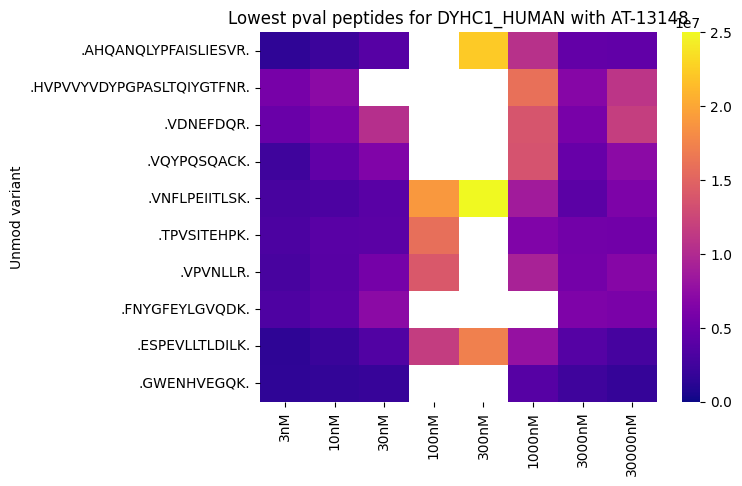

In [ ]:
sns.heatmap(d_4, cmap="plasma", vmin = 0, vmax=25000000)
plt.title("Lowest pval peptides for DYHC1_HUMAN with AT-13148")

In [ ]:
unique_match = df2[~df2['Proteins'].str.contains(';')]

Text(0.5, 1.0, 'Intensity of mean of DMSO')

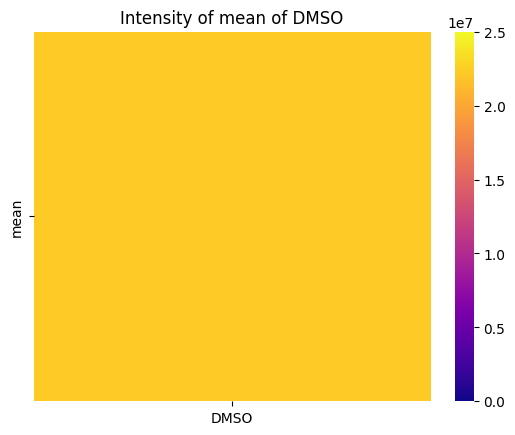

In [ ]:
m = np.mean(df2['DMSO'])
u = pd.DataFrame([m])
u = u.rename(index={0: "mean"}, columns={0: "DMSO"})
sns.heatmap(u, cmap="plasma", vmin = 0, vmax=25000000)
plt.title("Intensity of mean of DMSO")

In [ ]:
top_uniq = sorted(x)
top_uniq = top_uniq[:10]
top_uniq

[(0.00013333480979788143, '.LSFFFDFR.'),
 (0.00020615328265336782, '.ELNLVLSVR.'),
 (0.0005345148065770771, '.VLEALLPLK.'),
 (0.0005967015120945751, '.VSVHVIEGDHR.'),
 (0.0011398812085052538, '.DNLEFFLAGIGR.'),
 (0.0018337633601462002, '.QELSFAAR.'),
 (0.00435534819840029, '.EDGLAQQQTQLNLR.'),
 (0.0049073101973888976, '.LQLNGNLQLELAQVLAQERPK.'),
 (0.006346231222149514, '.GVDLVLNSLAEEK.'),
 (0.008155711031803861, '.EGGFLLLHTLLR.')]

In [ ]:
top_uniq = [lis[-1] for lis in top_uniq]
np.unique(top_uniq)

array(['.DNLEFFLAGIGR.', '.EDGLAQQQTQLNLR.', '.EGGFLLLHTLLR.',
       '.ELNLVLSVR.', '.GVDLVLNSLAEEK.', '.LQLNGNLQLELAQVLAQERPK.',
       '.LSFFFDFR.', '.QELSFAAR.', '.VLEALLPLK.', '.VSVHVIEGDHR.'],
      dtype='<U23')

In [ ]:
d_4 = df3.loc[df3['Unmod variant'].isin(top_uniq)]
d_4 = d_4.set_index('Unmod variant')
d_4 = d_4.drop(columns=['Variant', 'Proteins', 'DMSO'])
d_4.head()

,3nM,10nM,30nM,100nM,300nM,1000nM,3000nM,30000nM
Unmod variant,,,,,,,,
.LSFFFDFR.,1844500.0,1406400.0,5061100.0,15682000.0,13795000.0,7926100.0,4283600.0,4204200.0
.LQLNGNLQLELAQVLAQERPK.,3064000.0,5765200.0,13139000.0,NaN,38502000.0,23886000.0,6543100.0,9164400.0
.EGGFLLLHTLLR.,3438300.0,5349900.0,8444300.0,42355000.0,71028000.0,7433800.0,5555100.0,7695700.0
.EDGLAQQQTQLNLR.,7613300.0,7161800.0,15683000.0,32773000.0,32155000.0,28412000.0,17236000.0,20228000.0
.DNLEFFLAGIGR.,2413100.0,2707500.0,3209400.0,23623000.0,21691000.0,19773000.0,6125500.0,5995900.0


Text(0.5, 1.0, 'Lowest pval peptides for FAS_HUMAN with AT-13148')

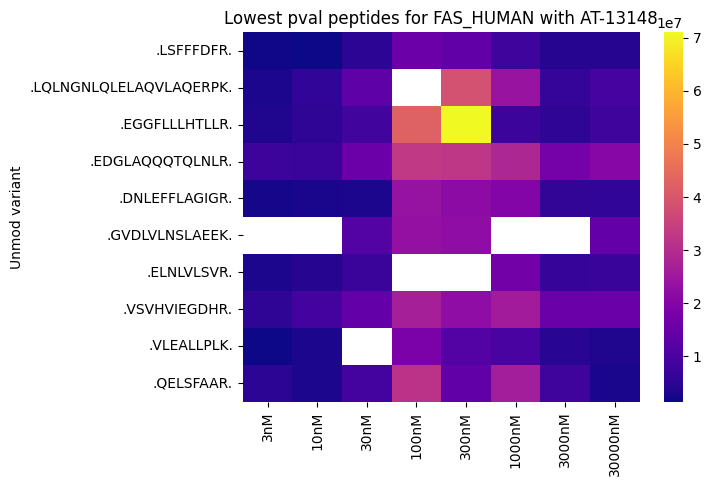

In [ ]:
sns.heatmap(d_4, cmap="plasma")
plt.title("Lowest pval peptides for FAS_HUMAN with AT-13148")

In [ ]:
top_uniq = sorted(y)
top_uniq = top_uniq[:10]
top_uniq

[(2.861749921436761e-11, '.VKDDIESLHDKFK.'),
 (1.0540702041593302e-10, '.LQGEFQLR.'),
 (9.72430470597095e-06, '.SVLVSAGNVK.'),
 (3.964751140020362e-05, '.SLLQALNEVK.'),
 (0.0002197152356074665, '.SNLPDNLKK.'),
 (0.000269859697022849, '.KLEHLITELVHQR.'),
 (0.0007458452158483241, '.GNEIVLSAGSTPR.'),
 (0.002454679071751966, '.LLNTFLER.'),
 (0.0038534070377480986, '.LGGSPFGPAGTGK.'),
 (0.005258128488722954, '.QLQNISLAAASGGAK.')]

In [ ]:
top_uniq = [lis[-1] for lis in top_uniq]
np.unique(top_uniq)

array(['.GNEIVLSAGSTPR.', '.KLEHLITELVHQR.', '.LGGSPFGPAGTGK.',
       '.LLNTFLER.', '.LQGEFQLR.', '.QLQNISLAAASGGAK.', '.SLLQALNEVK.',
       '.SNLPDNLKK.', '.SVLVSAGNVK.', '.VKDDIESLHDKFK.'], dtype='<U17')

In [ ]:
d_4 = df4.loc[df4['Unmod variant'].isin(top_uniq)]
d_4 = d_4.set_index('Unmod variant')
d_4 = d_4.drop(columns=['Variant', 'Proteins', 'DMSO'])
d_4.head()

,3nM,10nM,30nM,100nM,300nM,1000nM,3000nM,30000nM
Unmod variant,,,,,,,,
.VKDDIESLHDKFK.,NaN,NaN,NaN,5744500.0,5588300.0,5283200.0,5704000.0,NaN
.LQGEFQLR.,NaN,NaN,NaN,NaN,NaN,NaN,1285000.0,1267900.0
.SLLQALNEVK.,5059400.0,5646600.0,5430500.0,5557100.0,NaN,NaN,3679900.0,NaN
.QLQNISLAAASGGAK.,6793700.0,7421100.0,8949600.0,5721500.0,13017000.0,3312000.0,3363200.0,2630600.0
.GNEIVLSAGSTPR.,NaN,4227100.0,4837600.0,5604400.0,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Lowest pval peptides for DYHC1_HUMAN with Alectinib')

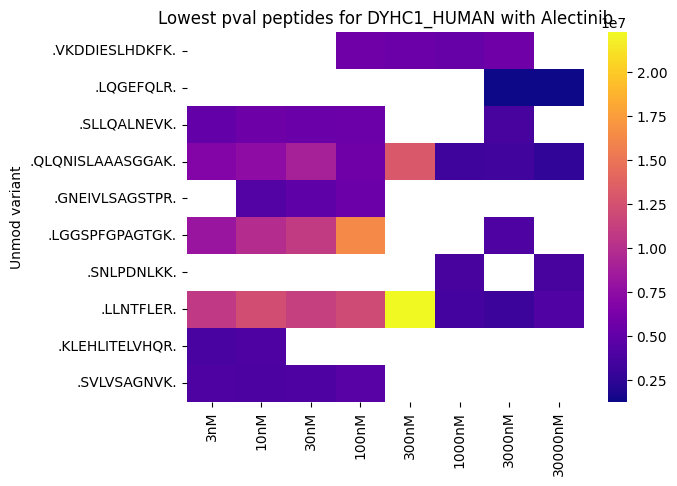

In [ ]:
sns.heatmap(d_4, cmap="plasma")
plt.title("Lowest pval peptides for DYHC1_HUMAN with Alectinib")